In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler,  StringIndexer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [96]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("ReadSnappyParquet").getOrCreate()

# Path to the .snappy.parquet file or directory
parquet_path = "file:/home/hdoop/Downloads/project-master/delta_lake/delta_lake_table_3/"

# Read the .snappy.parquet files
df = spark.read.parquet(parquet_path)

# Display the content
df.show()

# Print schema



+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible|
|2024-10-18 10:00:00|Hanoi|Vietnam| 21.0333|   105.85|  30.7|     5.1|    62.0|     0.29|   Light rain shower|
|

In [97]:
from pyspark.sql.functions import col, hour, dayofweek, month, quarter, dayofmonth, dayofyear
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql import functions as F

# 1. Tách các đặc trưng thời gian
df = df.withColumn("hour", hour(col("datetime"))) \
       .withColumn("day_of_week", dayofweek(col("datetime"))) \
       .withColumn("month", month(col("datetime"))) \
       .withColumn("quarter", quarter(col("datetime"))) \
       .withColumn("day_of_month", dayofmonth(col("datetime"))) \
       .withColumn("day_of_year", dayofyear(col("datetime")))

# 2. Kiểm tra và xử lý giá trị thiếu
df_final = df.fillna({"wind_mph": 0.0, "humidity": 50.0, "precip_mm": 0.0})  # Ví dụ: giá trị mặc định
indexer = StringIndexer(inputCol="condition", outputCol="condition_index")
df_final = indexer.fit(df_final).transform(df_final)

In [98]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Danh sách các cột đặc trưng
feature_columns = [
    "temp_c", "wind_mph", "humidity", "precip_mm", 
    "latitude", "longitude", "hour", "day_of_week", 
    "month", "quarter", "day_of_month", "day_of_year"
]




In [99]:
df_final.show()

+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|hour|day_of_week|month|quarter|day_of_month|day_of_year|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|   5|          6|   10|      4|          18|        292|            1.0|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|   6|          6|   10|      4|          18|        292|            1.0|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      

In [100]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Tạo VectorAssembler để kết hợp các cột đầu vào thành một vector
feature_columns = ['temp_c', 'wind_mph', 'humidity', 'precip_mm', 'latitude', 'longitude', 
                   'hour', 'day_of_week', 'month', 'quarter', 'day_of_month', 'day_of_year']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
df_final = assembler.transform(df_final)

# Chuyển đổi cột mục tiêu (condition_index) thành số (đã có trong dữ liệu)
df_final = df_final.withColumn("condition_index", df_final["condition_index"].cast("double"))

# Tách dữ liệu huấn luyện và kiểm tra
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Khởi tạo mô hình Gradient Boosting
gbt = GBTClassifier(featuresCol="features_vector", labelCol="condition_index", maxIter=100, seed=42)


In [101]:
df_final.show()

+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|hour|day_of_week|month|quarter|day_of_month|day_of_year|condition_index|     features_vector|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|   5|          6|   10|      4|          18|        292|            1.0|[25.0,3.1,89.0,0....|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|   6|          6|   10|      4|          18|        292|            1.0|[2

In [105]:
train_data.show()

+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|hour|day_of_week|month|quarter|day_of_month|day_of_year|condition_index|     features_vector|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+----+-----------+-----+-------+------------+-----------+---------------+--------------------+
|2024-04-20 15:00:00|Hanoi|Vietnam| 21.0333|   105.85|  37.8|     8.1|    37.0|      0.0|               Sunny|  15|          7|    4|      2|          20|        111|            5.0|[37.8,8.1,37.0,0....|
|2024-04-20 16:00:00|Hanoi|Vietnam| 21.0333|   105.85|  37.0|    14.5|    40.0|      0.0|               Sunny|  16|          7|    4|      2|          20|        111|            5.0|[3

In [106]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Tách dữ liệu huấn luyện và kiểm tra
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Khởi tạo mô hình Gradient Boosting
gbt = GBTClassifier(featuresCol="features_vector", labelCol="condition_index", maxIter=100, maxDepth=5, seed=42)

# Huấn luyện mô hình
gbt_model = gbt.fit(train_data)

# Dự đoán trên dữ liệu kiểm tra
predictions = gbt_model.transform(test_data)

# Đánh giá độ chính xác
evaluator = MulticlassClassificationEvaluator(labelCol="condition_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# In kết quả độ chính xác
print(f"Accuracy: {accuracy:.2%}")


24/12/03 20:11:44 ERROR Executor: Exception in task 0.0 in stage 2627.0 (TID 15614)
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at

Py4JJavaError: An error occurred while calling o3373.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 2627.0 failed 1 times, most recent failure: Lost task 0.0 in stage 2627.0 (TID 15614) (10.10.91.225 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1492)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1465)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:119)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


Hoan thanh

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Khởi tạo mô hình
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="condition_index", numTrees=50 )

# Huấn luyện mô hình
rf_model = rf.fit(train_data)

# Dự đoán trên tập kiểm tra
predictions = rf_model.transform(test_data)

# Đánh giá kết quả
evaluator = MulticlassClassificationEvaluator(labelCol="condition_index", 
                                               predictionCol="prediction", 
                                               metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 57.44%


In [ ]:
rf = RandomForestClassifier(
    featuresCol="features_vector",
    labelCol="condition_index",
    numTrees=200,       # Tăng số cây
    maxDepth=15,        # Tăng độ sâu
    maxBins=64,         # Số lượng phân vùng
    seed=42
)

rf_model = rf.fit(train_data)
predictions_rf = rf_model.transform(test_data)

accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest Improved Accuracy: {accuracy_rf:.2%}")


24/12/02 21:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB
24/12/02 21:25:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/12/02 21:25:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/12/02 21:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1273.0 KiB
24/12/02 21:25:26 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
24/12/02 21:25:27 WARN DAGScheduler: Broadcasting large task binary with size 2038.1 KiB
24/12/02 21:25:29 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
24/12/02 21:25:31 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/02 21:25:33 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
24/12/02 21:25:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/12/02 21:25:38 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
24/12/02 21:25:40 WARN DAGScheduler: Broad

Random Forest Improved Accuracy: 75.81%


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features_vector", labelCol="condition_index", maxIter=10)
lr_model = lr.fit(train_data)
predictions_lr = lr_model.transform(test_data)

accuracy_lr = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2%}")


24/12/02 21:26:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Accuracy: 43.09%


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    featuresCol="features_vector",
    labelCol="condition_index",
    maxDepth=10
)

dt_model = dt.fit(train_data)
predictions_dt = dt_model.transform(test_data)

accuracy_dt = evaluator.evaluate(predictions_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2%}")


Decision Tree Accuracy: 65.57%


In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features_vector", labelCol="condition_index", smoothing=1.0)
nb_model = nb.fit(train_data)
predictions_nb = nb_model.transform(test_data)

accuracy_nb = evaluator.evaluate(predictions_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2%}")


Naive Bayes Accuracy: 22.80%


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Định nghĩa mô hình
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="condition_index", seed=42)

# Tạo grid các siêu tham số cần tối ưu
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [16, 32, 64]) \
    .build()  # Thêm .build() ở đây

# Định nghĩa bộ đánh giá
evaluator = MulticlassClassificationEvaluator(labelCol="condition_index", metricName="accuracy")

# Sử dụng CrossValidator
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3  # 3-fold cross-validation
)

# Huấn luyện
cv_model = cv.fit(train_data)

# Dự đoán
predictions = cv_model.transform(test_data)

# Đánh giá mô hình tốt nhất
best_accuracy = evaluator.evaluate(predictions)
print(f"Best Model Accuracy: {best_accuracy:.2%}")

# In siêu tham số tốt nhất
best_model = cv_model.bestModel
print(f"Best Parameters: numTrees = {best_model.getNumTrees}, maxDepth = {best_model.getMaxDepth}, maxBins = {best_model.getMaxBins}")


24/12/02 21:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1221.8 KiB
24/12/02 21:31:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/12/02 21:31:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/12/02 21:31:36 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/12/02 21:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
24/12/02 21:31:37 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
24/12/02 21:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1284.2 KiB
24/12/02 21:31:38 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/12/02 21:31:39 WARN DAGScheduler: Broadcasting large task binary with size 1205.3 KiB
24/12/02 21:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/12/02 21:31:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/12/02 21:31:41 WARN DAGScheduler: Broad

Best Model Accuracy: 75.81%
Best Parameters: numTrees = 200, maxDepth = <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_c4e1997179af, numTrees=200, numClasses=21, numFeatures=12>, maxBins = <bound method _DecisionTreeParams.getMaxBins of RandomForestClassificationModel: uid=RandomForestClassifier_c4e1997179af, numTrees=200, numClasses=21, numFeatures=12>


In [ ]:
# Kiểm tra cấu trúc dữ liệu
df_final.printSchema()

# Kiểm tra thống kê cơ bản
df_final.describe().show()

# Kiểm tra số lượng giá trị null
from pyspark.sql.functions import col, sum
null_counts = df_final.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_final.columns])
null_counts.show()


root
 |-- datetime: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- wind_mph: double (nullable = false)
 |-- humidity: double (nullable = false)
 |-- precip_mm: double (nullable = false)
 |-- condition: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_year: integer (nullable = true)
 |-- condition_index: double (nullable = false)



24/12/02 21:26:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+-------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary| name|country|          latitude|         longitude|            temp_c|          wind_mph|          humidity|          precip_mm|           condition|             hour|       day_of_week|             month|           quarter|      day_of_month|      day_of_year|   condition_index|
+-------+-----+-------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count| 7776|   7776|              7776|              7776|              7776|              7776|              7776|         

In [ ]:
# Phân phối các giá trị
for column in ['temp_c', 'wind_mph', 'humidity', 'precip_mm']:
    df_final.select(column).describe().show()


+-------+------------------+
|summary|            temp_c|
+-------+------------------+
|  count|              7776|
|   mean| 25.76966306584362|
| stddev|5.0961428389531855|
|    min|               8.9|
|    max|              43.8|
+-------+------------------+

+-------+------------------+
|summary|          wind_mph|
+-------+------------------+
|  count|              7776|
|   mean| 6.201234567901236|
| stddev|3.2282707813478018|
|    min|               0.0|
|    max|              23.5|
+-------+------------------+

+-------+------------------+
|summary|          humidity|
+-------+------------------+
|  count|              7776|
|   mean|  75.4769804526749|
| stddev|14.633397380884748|
|    min|              12.0|
|    max|              99.0|
+-------+------------------+

+-------+-------------------+
|summary|          precip_mm|
+-------+-------------------+
|  count|               7776|
|   mean|0.22119212962962953|
| stddev| 0.6708579187375706|
|    min|                0.0|
|   

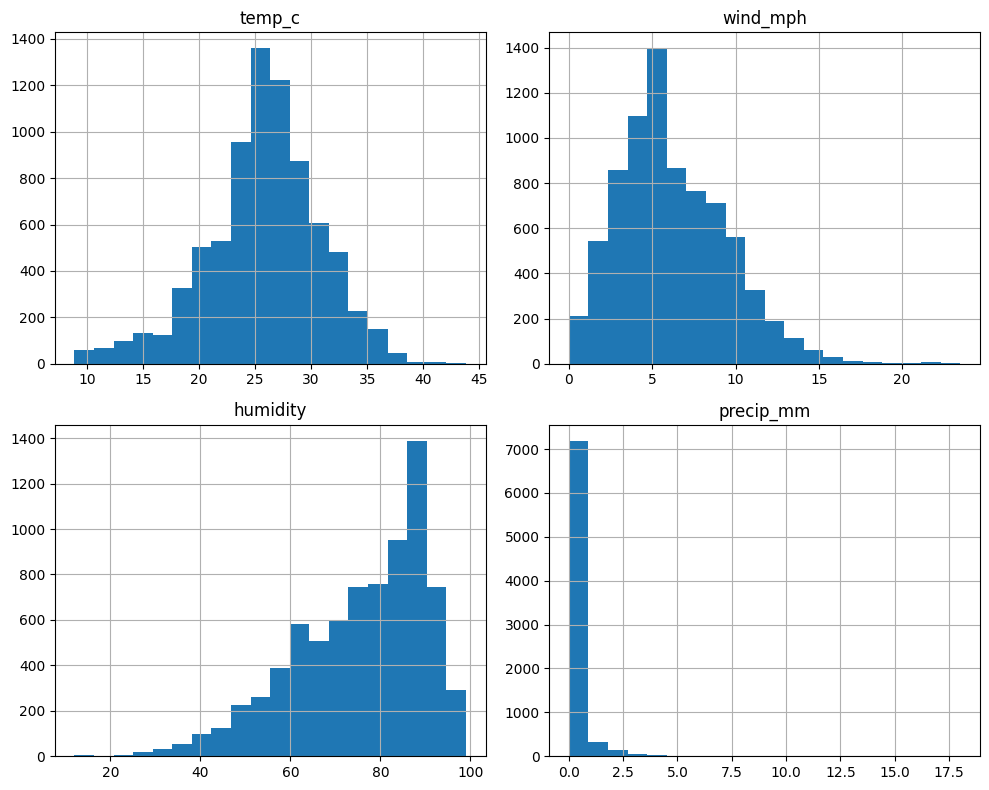

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển dữ liệu sang Pandas DataFrame
pandas_df = df_final.toPandas()

# Vẽ histogram
pandas_df[['temp_c', 'wind_mph', 'humidity', 'precip_mm']].hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()


In [ ]:
# Đếm số lượng từng điều kiện thời tiết
df.groupBy("condition").count().orderBy("count", ascending=False).show()


+--------------------+-----+
|           condition|count|
+--------------------+-----+
|Patchy rain possible| 2273|
|       Partly cloudy| 1250|
|            Overcast|  758|
|               Clear|  651|
|   Light rain shower|  642|
|               Sunny|  640|
|              Cloudy|  459|
|Thundery outbreak...|  277|
|       Light drizzle|  274|
|                Mist|  142|
|          Light rain|   96|
|Patchy light drizzle|   84|
|Moderate or heavy...|   68|
|   Patchy light rain|   45|
|Patchy light rain...|   42|
|       Moderate rain|   40|
|Moderate rain at ...|   16|
|Moderate or heavy...|   12|
|                 Fog|    4|
|          Heavy rain|    2|
+--------------------+-----+
only showing top 20 rows



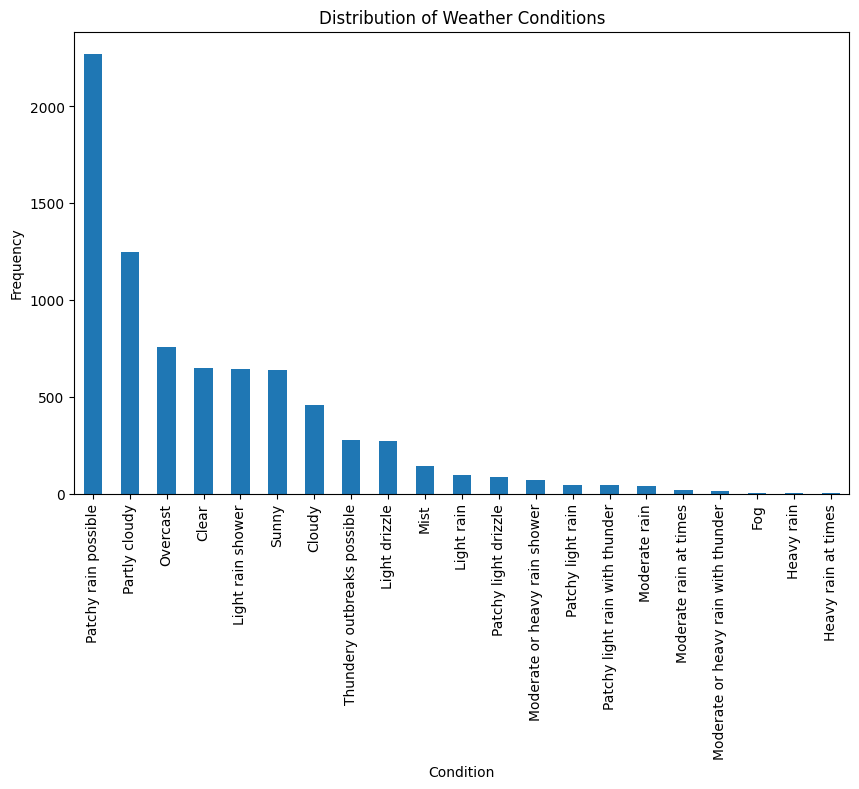

In [ ]:
# Sử dụng Matplotlib để vẽ bar chart
condition_counts = pandas_df['condition'].value_counts()
condition_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Weather Conditions")
plt.xlabel("Condition")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Tính hệ số tương quan giữa các cột liên tục
correlation_matrix = pandas_df[['temp_c', 'wind_mph', 'humidity', 'precip_mm', 'condition_index']].corr()
print(correlation_matrix)


                   temp_c  wind_mph  humidity  precip_mm  condition_index
temp_c           1.000000  0.022048 -0.382006   0.053359         0.129584
wind_mph         0.022048  1.000000 -0.137781   0.038812        -0.000925
humidity        -0.382006 -0.137781  1.000000   0.213409         0.043013
precip_mm        0.053359  0.038812  0.213409   1.000000         0.463704
condition_index  0.129584 -0.000925  0.043013   0.463704         1.000000


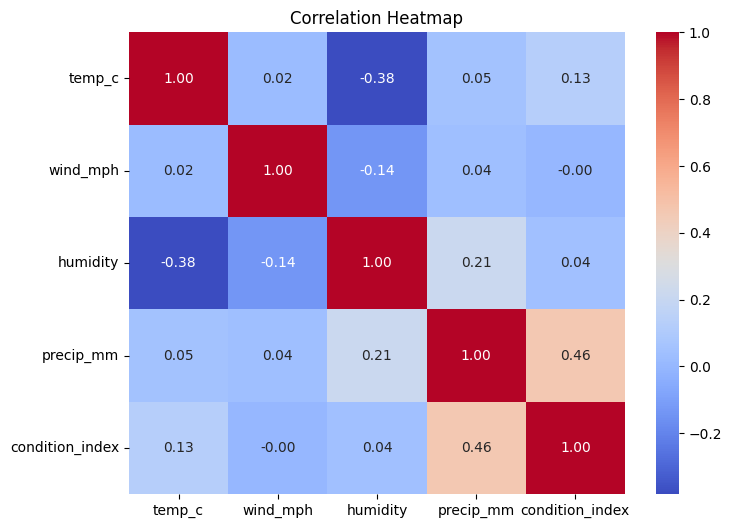

In [ ]:
import seaborn as sns

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from pyspark.sql.functions import hour, dayofweek, month

df_check = df.withColumn("hour", hour("datetime")) \
                   .withColumn("day_of_week", dayofweek("datetime")) \
                   .withColumn("month", month("datetime"))

# Trung bình nhiệt độ theo giờ
df_check.groupBy("hour").mean("temp_c").orderBy("hour").show()


+----+------------------+
|hour|       avg(temp_c)|
+----+------------------+
|   0|24.098456790123457|
|   1|23.906172839506173|
|   2| 23.74413580246914|
|   3| 23.56172839506173|
|   4| 23.41697530864198|
|   5| 23.28333333333333|
|   6|23.294444444444448|
|   7| 23.87253086419753|
|   8|24.802469135802465|
|   9|25.839506172839513|
|  10|26.896913580246913|
|  11|27.846604938271607|
|  12|28.550617283950622|
|  13|29.076543209876547|
|  14|29.309259259259267|
|  15|29.242592592592587|
|  16|  28.7716049382716|
|  17|27.916049382716047|
|  18| 26.63858024691358|
|  19|25.751543209876544|
+----+------------------+
only showing top 20 rows



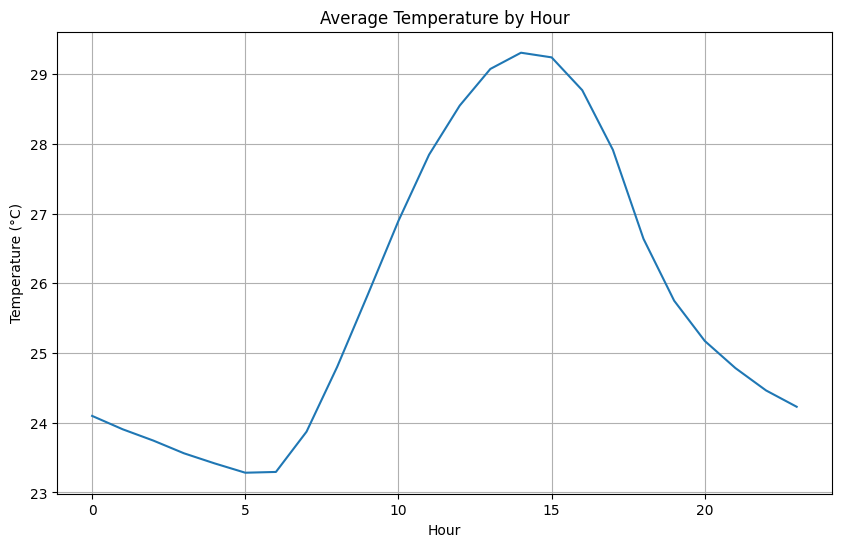

In [ ]:
# Trung bình nhiệt độ theo giờ (sử dụng Pandas DataFrame)
hourly_temp = pandas_df.groupby("hour")['temp_c'].mean()
hourly_temp.plot(kind='line', figsize=(10, 6))
plt.title("Average Temperature by Hour")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Chuẩn bị dữ liệu
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_rf = assembler.transform(df_final)

# Huấn luyện Random Forest
rf = RandomForestClassifier(labelCol="condition_index", featuresCol="features", numTrees=50)
rf_model = rf.fit(df_rf)

# In độ quan trọng của đặc trưng
feature_importances = rf_model.featureImportances
print("Feature Importances:", list(zip(feature_columns, feature_importances)))


Feature Importances: [('temp_c', np.float64(0.08120040295926165)), ('wind_mph', np.float64(0.010917996771750286)), ('humidity', np.float64(0.1040468404670542)), ('precip_mm', np.float64(0.6195917837258637)), ('latitude', np.float64(0.0)), ('longitude', np.float64(0.0)), ('hour', np.float64(0.030201376630894932)), ('day_of_week', np.float64(0.0047064666258095425)), ('month', np.float64(0.04347965646648782)), ('quarter', np.float64(0.026823975194073008)), ('day_of_month', np.float64(0.017252015900456726)), ('day_of_year', np.float64(0.06177948525834818))]


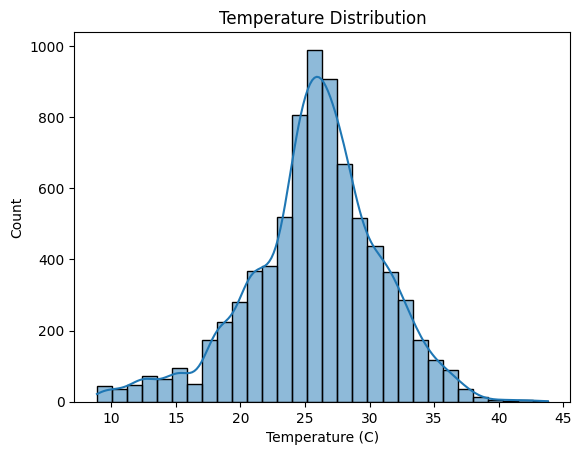

In [ ]:
import seaborn as sns

temp_data = df_final.select("temp_c").toPandas()
sns.histplot(temp_data['temp_c'], kde=True, bins=30)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (C)")
plt.show()


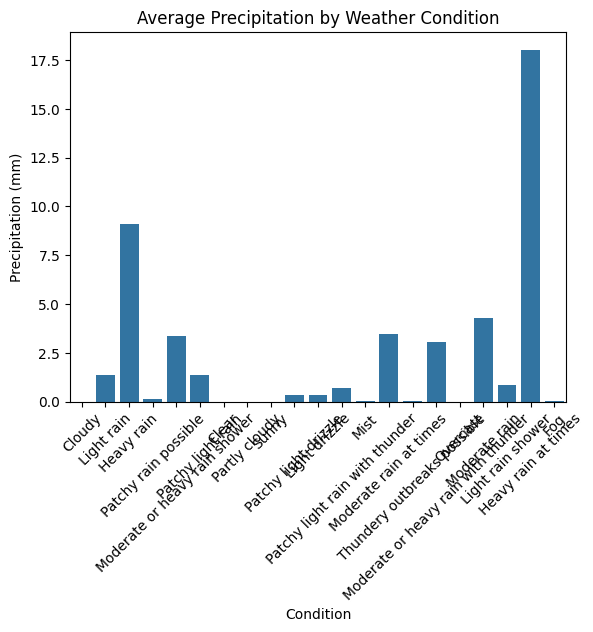

In [ ]:
precip_data = df_final.groupBy("condition").agg({"precip_mm": "mean"}).toPandas()
sns.barplot(x="condition", y="avg(precip_mm)", data=precip_data)
plt.xticks(rotation=45)
plt.title("Average Precipitation by Weather Condition")
plt.xlabel("Condition")
plt.ylabel("Precipitation (mm)")
plt.show()
